### > Setup ffmpeg

In [ ]:
%%sh
sudo apt-get update && sudo apt upgrade -y

sudo apt-get install ffmpeg -y

pip install -U sagemaker

### > Initialize parameters

In [32]:
import boto3
import sagemaker
from sagemaker.utils import name_from_base
import shutil
import os

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
region = sagemaker_session._region_name

prefix = "multi-modal-search"

s3_client = boto3.client('s3')

video_dir = 'videos' # BigBuckBunny.mp4' #TearsOfSteel.mp4'  #

# load the host and index_name for opensearch
%store -r host
%store -r index_name

print(f"Opensearch hosting url: {host}")
print(f"Opensearch index name: {index_name}")

Opensearch hosting url: 9bmvaevz935xeno6njp4.us-west-2.aoss.amazonaws.com
Opensearch index name: mm-search-2024-03-22-22-01-30-089


### > download and setup videos

In [33]:
if os.path.exists(video_dir):
    # Remove existing folder
    shutil.rmtree(video_dir)
    
# Create new folder
os.makedirs(video_dir)

In [34]:
videos=[
    # “Shooting in motion for a football player”
    "https://d286ovwbajn9p7.cloudfront.net/AdobeStock_161973588.mov",
    # “Race to the Cloud”
    "https://d286ovwbajn9p7.cloudfront.net/RaceToTheCloud_444_PR_M_040623-FINAL_264.mp4",
    # "Picchu"
    "https://d286ovwbajn9p7.cloudfront.net/aws-picchu-edit-rendered.mp4",
    # "AWS España Ya disponible"
    "https://d286ovwbajn9p7.cloudfront.net/AWS_Espa%C3%B1a_Ya%20disponible.mp4",
    # "Christmas fire"
    "https://d286ovwbajn9p7.cloudfront.net/AdobeStock_384597062.mov",
    # "westiepoo"
    "https://d2yqlwoly7fl0b.cloudfront.net/super-slomo/samples/westiepoo.mov",
]

In [35]:
for v in videos:
    print(v)
    !cd {video_dir} && wget {v} --no-check-certificate

https://d286ovwbajn9p7.cloudfront.net/AdobeStock_161973588.mov
--2024-03-23 00:29:12--  https://d286ovwbajn9p7.cloudfront.net/AdobeStock_161973588.mov
Resolving d286ovwbajn9p7.cloudfront.net (d286ovwbajn9p7.cloudfront.net)... 3.163.19.182, 3.163.19.49, 3.163.19.30, ...
Connecting to d286ovwbajn9p7.cloudfront.net (d286ovwbajn9p7.cloudfront.net)|3.163.19.182|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 21564633 (21M) [video/quicktime]
Saving to: ‘AdobeStock_161973588.mov’

AdobeStock_16197358 100%[===================>]  20.57M  98.2MB/s    in 0.2s    

2024-03-23 00:29:13 (98.2 MB/s) - ‘AdobeStock_161973588.mov’ saved [21564633/21564633]

https://d286ovwbajn9p7.cloudfront.net/RaceToTheCloud_444_PR_M_040623-FINAL_264.mp4
--2024-03-23 00:29:13--  https://d286ovwbajn9p7.cloudfront.net/RaceToTheCloud_444_PR_M_040623-FINAL_264.mp4
Resolving d286ovwbajn9p7.cloudfront.net (d286ovwbajn9p7.cloudfront.net)... 3.163.19.

In [36]:
# !cd {video_dir} && curl https://gist.githubusercontent.com/jsturgis/3b19447b304616f18657/raw/a8c1f60074542d28fa8da4fe58c3788610803a65/gistfile1.txt | grep -o 'http[^"]*.mp4' | xargs -n 1 curl -O

### > upload videos to S3

In [37]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [38]:
s3_video_dir=f"s3://{bucket}/{prefix}/videos/"

!aws s3 sync {video_dir} {s3_video_dir}

In [39]:
from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role

#Initialize the PyTorchProcessor
pytorch_processor = PyTorchProcessor(
    framework_version='2.0',
    py_version="py310",
    role=get_execution_role(),
    instance_type='ml.g4dn.4xlarge',
    instance_count=1,
    base_job_name=name_from_base(prefix)
)

#Run the processing job
pytorch_processor.run(
    code='video_ingestion.py',
    source_dir='code_dir',
    arguments=["--host", host, "--index_name", index_name, 
              "--prefix", prefix, "--bucket", bucket],
    inputs=[
        ProcessingInput(
            input_name='videos',
            source=s3_video_dir,
            destination='/opt/ml/processing/input/videos'
        )
    ]
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.processing:Uploaded code_dir to s3://sagemaker-us-west-2-374212921621/multi-modal-search-2024-03-23-00-29-34--2024-03-23-00-29-34-568/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-west-2-374212921621/multi-modal-search-2024-03-23-00-29-34--2024-03-23-00-29-34-568/source/runproc.sh
INFO:sagemaker:Creating processing-job with name multi-modal-search-2024-03-23-00-29-34--2024-03-23-00-29-34-568


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 170.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 185.1 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.32.7
    Uninstalling botocore-1.32.7:
      Successfully uninstalled botocore-1.32.7
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.8.0
    Uninstalling s3transfer-0.8.0:
      Successfully uninstalled s3transfer-0.8.0
  Attempting uninstall: boto3


### > Local ingestion testing

In [2]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [3]:
try:
    entries = os.scandir("dog")#video_dir)
except FileNotFoundError as e:
    print(f"Could not scan folder: {e}")
    raise
except OSError as e: 
    print(f"Could not scan folder: {e}")
    raise

### > Process videos

The processing include following steps:
1. extract key frames from video
2. upload to s3 and build the index
3. ingest index to opensearch

In [4]:
from code_dir.helper import extract_key_frames, upload_frames
from code_dir.opensearch_util import bulk_index_ingestion
from tqdm import tqdm

for entry in tqdm(entries):
    try:
        if entry.is_file() and entry.path.endswith((".mp4", ".mkv", ".mov")): 

            print(f"process file: {entry.path}...")
            # extract key frames from video
            output_dir, fps = extract_key_frames(entry.path)
            print(f"frame rate is {fps} per second")

            print(f"number of frames: {len(os.listdir(output_dir))}")
            # upload fames to s3
            frames = upload_frames(output_dir, bucket, prefix, entry.path.split('/')[-1], fps)
            print(f"upload frames to s3 bucket...")

            # ingest the index file into opensearch
            sucess, failed = bulk_index_ingestion(host, index_name, frames)
            
    except OSError as e: 
        print(f"Could not read entry {entry.path}: {e}")

0it [00:00, ?it/s]

process file: dog/westiepoo.mov...
frame rate is 25.0 per second
number of frames: 1
upload frames to s3 bucket...


1it [00:06,  6.61s/it]

Indexed 2 documents


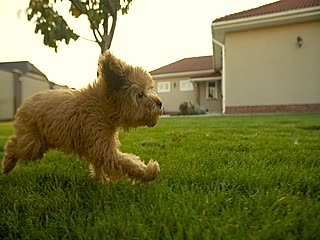

In [5]:
import os
import random
from IPython.display import display, Image

# Get a list of all image files in the folder
image_files = [f for f in os.listdir(output_dir) if f.endswith(('.jpg', '.png', '.gif'))]

# Display the sampled images
for image_file in image_files:
    image_path = os.path.join(output_dir, image_file)
    display(Image(filename=image_path))

### > Test Multi-modal text search

In [25]:
# build opensearch query
query = {
    "size": 10,
    "query":{
        "knn": {
        "multimodal_vector": {
            "vector": [],
            "k": 5
        }
        }
    },
    "_source": ["video", 
                "bucket", 
                "video_key" , 
                "frame_key", 
                "caption", 
                "timestamp", 
                "embedding_type"]

    }

In [46]:
from code_dir.helper import opensearch_query, render_search_result, get_embedding, encode_image_to_base64
from IPython.display import display, clear_output


query["query"]["knn"]["multimodal_vector"]["vector"] = get_embedding(text_description="Show me a race car driver")
        
results = opensearch_query(query,
                            host=host,
                           index_name=index_name)

display(render_search_result(results))

INFO:opensearch:POST https://9bmvaevz935xeno6njp4.us-west-2.aoss.amazonaws.com:443/mm-search-2024-03-22-22-01-30-089/_search [status:200 request:0.101s]


### > Test MM mage Search

In [27]:
image_base64 = encode_image_to_base64("test-image.jpg")

query["query"]["knn"]["multimodal_vector"]["vector"] = get_embedding(image_base64=image_base64)
        
results = opensearch_query(query, 
                           host = host,
                           index_name=index_name)

display(render_search_result(results))

INFO:opensearch:POST https://9bmvaevz935xeno6njp4.us-west-2.aoss.amazonaws.com:443/mm-search-2024-03-21-17-08-30-583/_search [status:200 request:0.087s]


### > Interactive UI

Have fun.....!

Here are some sample prompts:

- cute dog running on grass
- flying squiral
- a bunny flying a kite
- Game of thrones

In [28]:
import ipywidgets as ipw
class ChatUX:
    """ A chat UX using IPWidgets
    """
    def __init__(self, qa):
        self.qa = qa
        self.name = None
        self.b=None
        self.out = ipw.Output()
        self.session_id = None

    def start_chat(self):
        print("Let's chat!")
        display(self.out)
        self.chat(None)

    def chat(self, _):
        if self.name is None:
            prompt = ""
        else:
            prompt = self.name.value
        if 'q' == prompt or 'quit' == prompt or 'Q' == prompt:
            print("Thank you , that was a nice chat !!")
            return
        elif len(prompt) > 0:
            with self.out:
                thinking = ipw.Label(value=f"Thinking...")
                display(thinking)
                try:
                    query["query"]["knn"]["multimodal_vector"]["vector"] = get_embedding(text_description=prompt)
                    results = opensearch_query(query,
                                               host=host,
                                               index_name=index_name)

                    output_results = render_search_result(results)
                except Exception as e:
                    print(e)
                    output_results = "No answer"

                thinking.value=""
                print("AI:")
                display(output_results)
                self.name.disabled = True
                self.b.disabled = True
                self.name = None

        if self.name is None:
            with self.out:
                self.name = ipw.Text(description="You: ", placeholder='q to quit')
                self.b = ipw.Button(description="Send")
                self.b.on_click(self.chat)
                display(ipw.Box(children=(self.name, self.b)))

In [29]:
agent_runtime_client = boto3.client('bedrock-runtime')

chat = ChatUX(agent_runtime_client)
chat.start_chat()

Let's chat!


Output()